<a href="https://colab.research.google.com/github/maciejskorski/autocorrelations_trng/blob/main/notebooks/drift_pseudorandomness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

Recall that raw bits generated from oscillator-based TRNG are sampled first digits of Brownian motion with drift.

How does this drift impact pseudorandom properties and autocorrelation?

In [ ]:
# run to install on Colab

!pip install --upgrade pip --quiet
!git clone https://github.com/maciejskorski/deep_correlations_trng.git --quiet
%cd deep_correlations_trng
!pip install . --quiet

In [14]:
try:
    from importlib.resources import files
except:
    from importlib_resources import files
from deep_correlations_trng.utils import read_bits
from deep_correlations_trng import data

from statsmodels.graphics.tsaplots import acf,plot_acf
import matplotlib.pyplot as plt
import numpy as np
import scipy

import re

plt.style.use('ggplot')


plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Patterns

* In terms of autocorrelation, we expect quasi-periodicity due to drift and decay due to jitter accumulation.

* Quasi-periodicity may appear at higher or lower frequencies, depending on the ratio of the referencing and sampled signal frequencies.

* The drift can be (approximately) recovered by Power Spectral Density estimation



## Synthetic Data

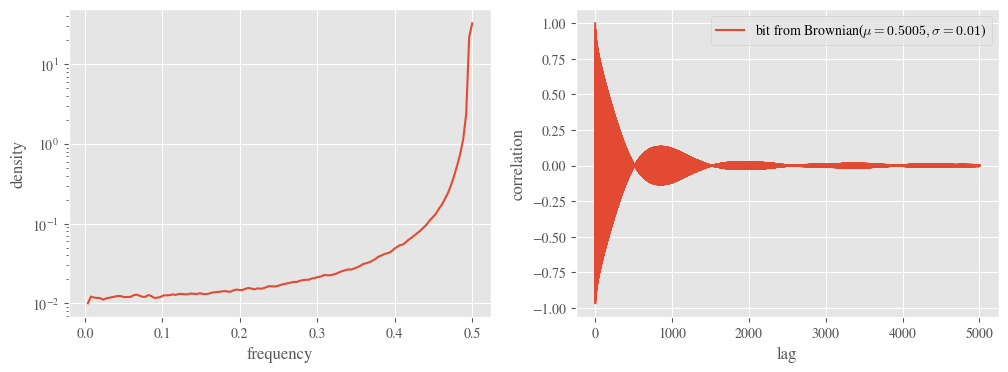

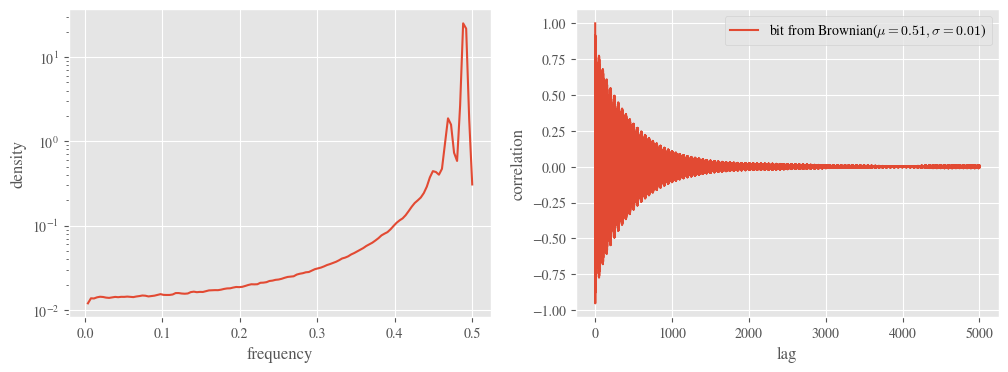

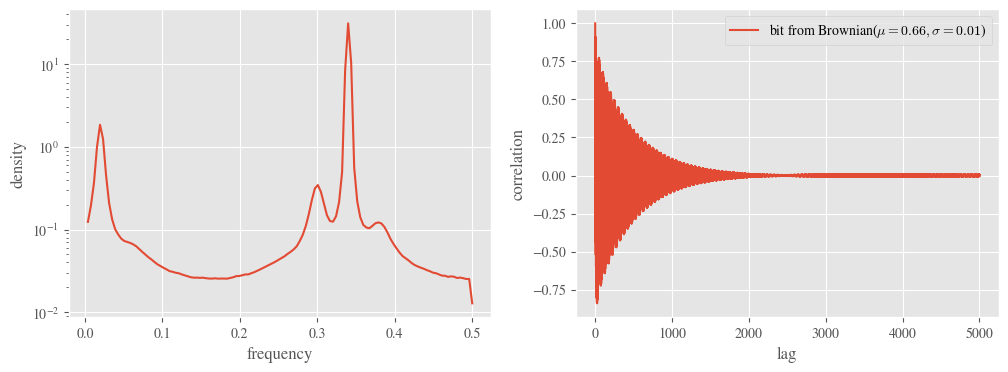

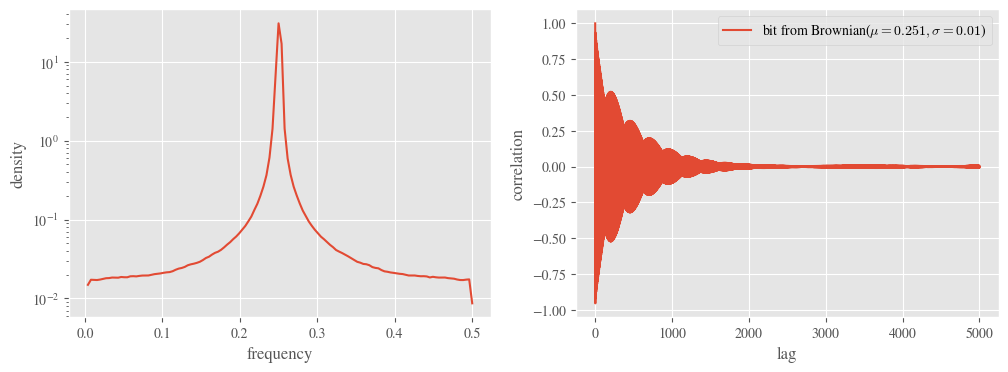

In [5]:
sigma = 0.01
for mu in [0.5005,0.51,0.66,0.251]:
    location = np.cumsum(np.random.normal(mu,sigma,size=(10000000)))
    phases = (0.0+location)%1
    bits = (phases < 1/2).astype('int')
    fig,axs = plt.subplots(1,2,figsize=(12,4))

    ax = axs[0]
    (fs, fs_power) = scipy.signal.welch(bits[-1000000:], fs=1.0, scaling='density')
    ax.semilogy(fs[1:], fs_power[1:])
    ax.set_xlabel('frequency')
    ax.set_ylabel('density')

    ax = axs[1]
    nlags = 5000
    lags = np.arange(nlags+1)
    ax.plot(lags, acf(bits,nlags=nlags,fft=True),label=f'bit from Brownian($\mu={mu},\sigma={sigma}$)')
    ax.legend()
    ax.set_xlabel('lag')
    ax.set_ylabel('correlation')

    plt.show()

## Real Data

In [53]:
def get_frequencies(log_path,freq_pattern = re.compile('(\d+\.\d+\sMHz)')):
    """ Parse the log file to extract frequencies """
    with open(log_path,'r') as f:
        log_txt = '\n'.join(f.readlines())
        return freq_pattern.findall(log_txt)

In [11]:
!ls ..

README.md      notebooks      pyproject.toml src


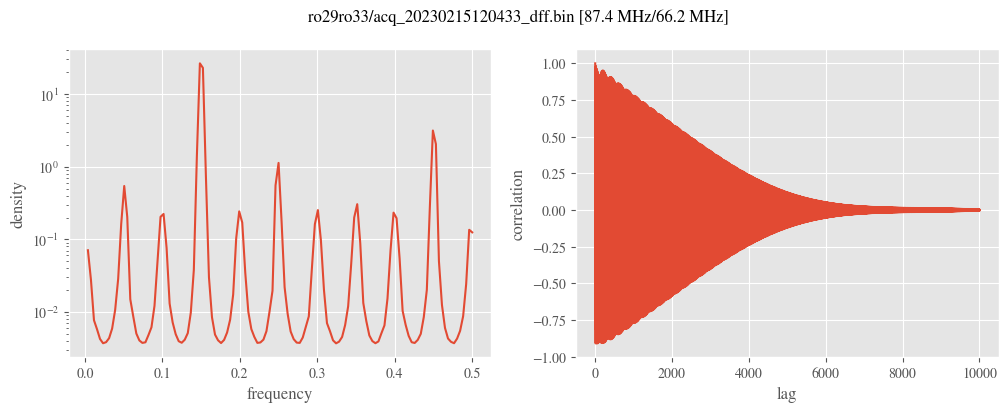

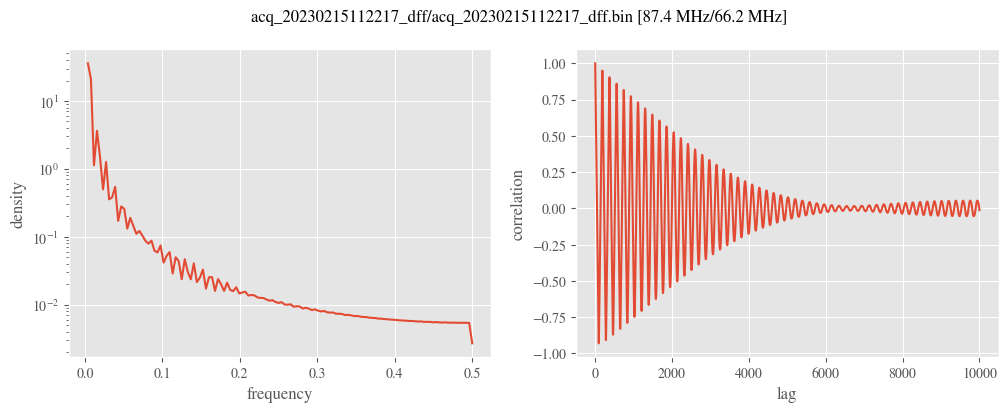

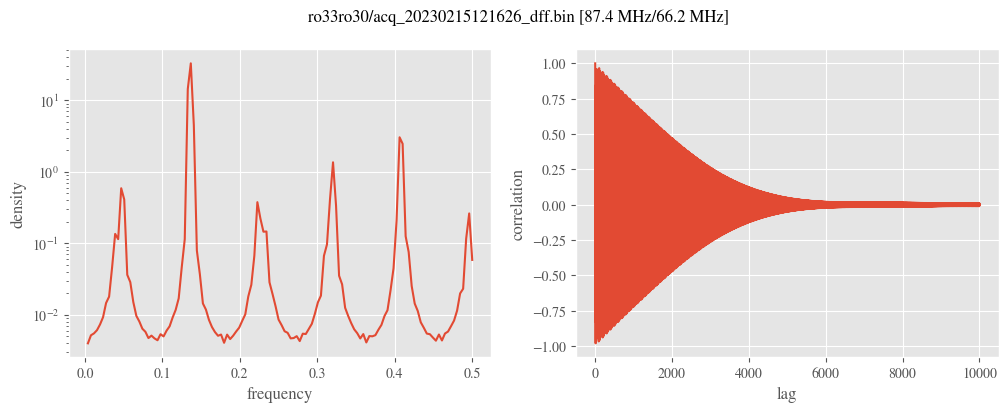

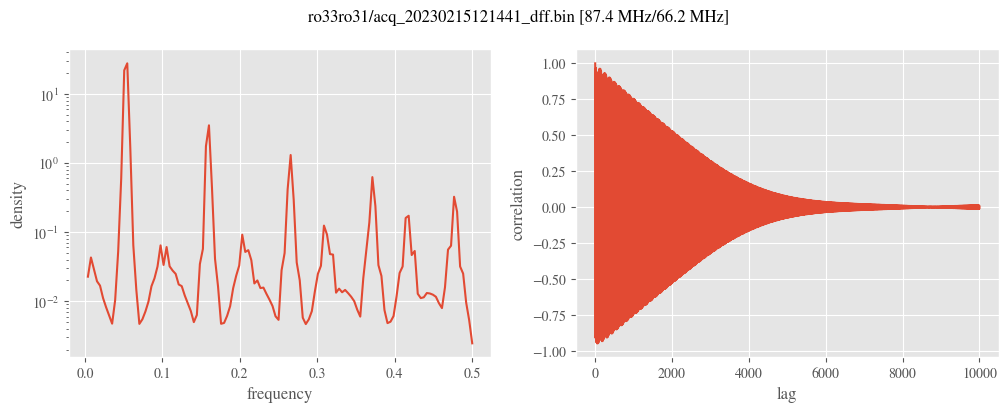

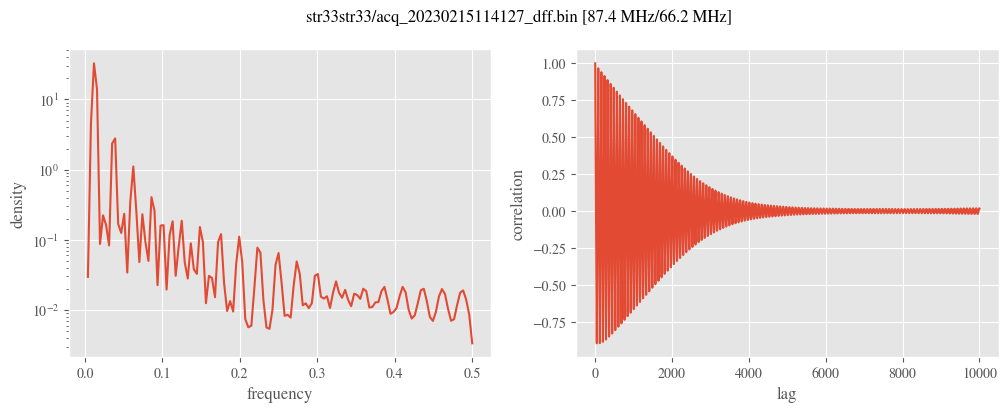

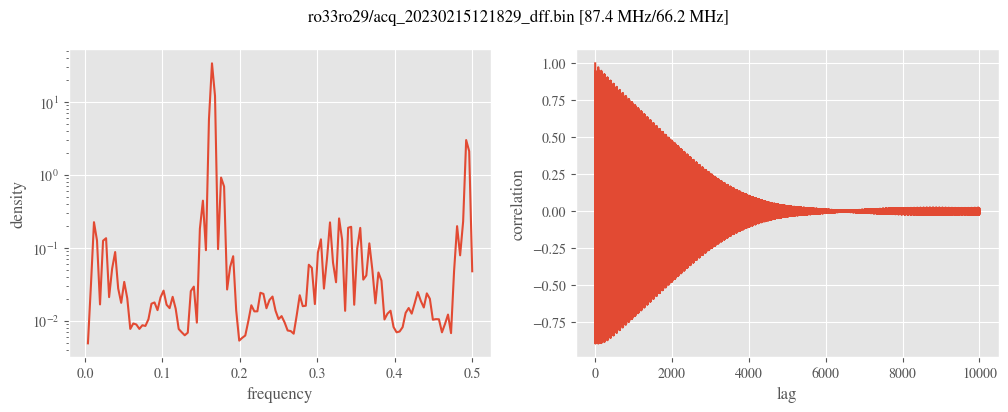

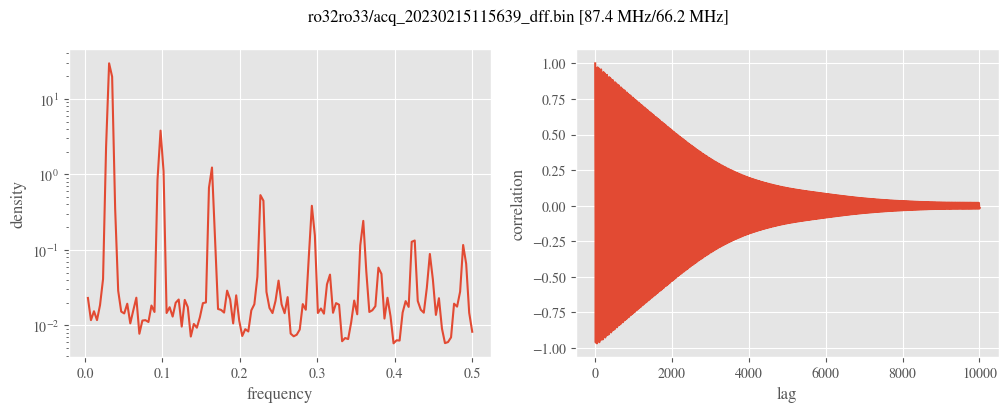

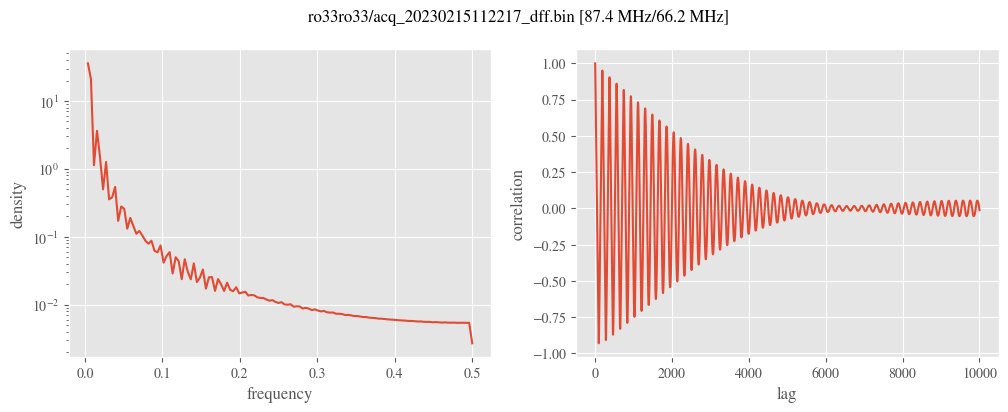

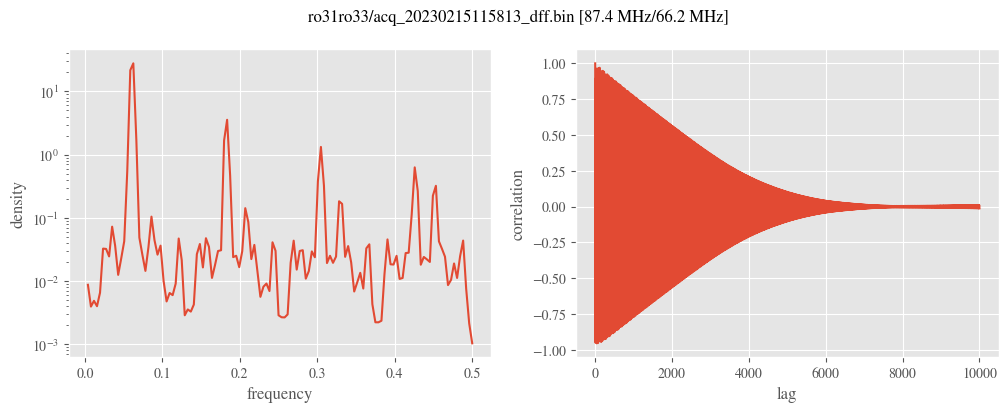

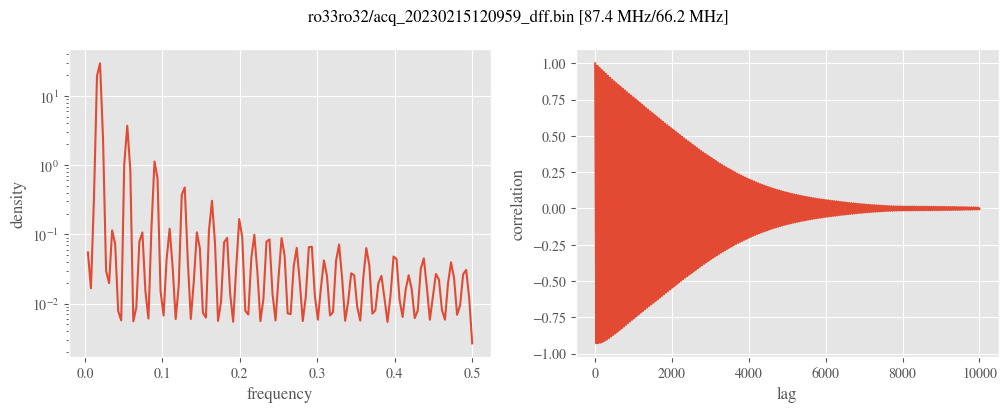

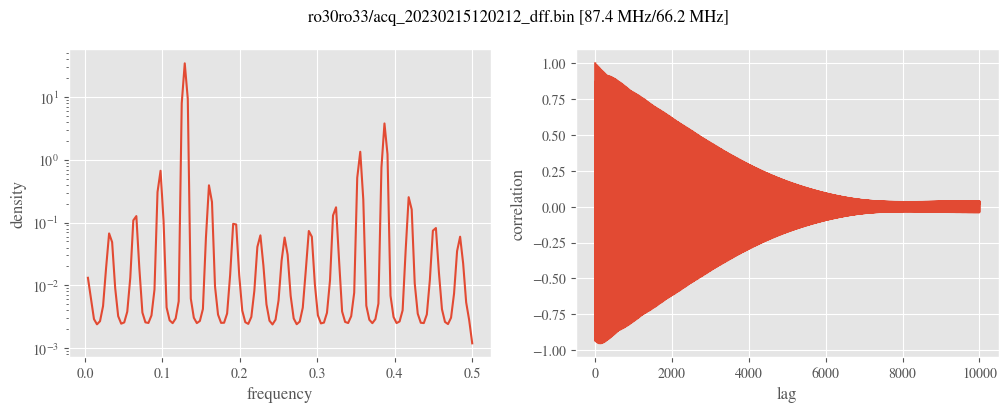

In [56]:
data_files = list(files(data).joinpath('230215_2').rglob('*/*.bin'))


for fname in data_files:
    bits = read_bits(fname)

    fig,axs = plt.subplots(1,2,figsize=(12,4))

    ax = axs[0]
    (fs, fs_power) = scipy.signal.welch(bits[-1000000:], fs=1.0, scaling='density')
    ax.semilogy(fs[1:], fs_power[1:])
    ax.set_xlabel('frequency')
    ax.set_ylabel('density')
    #ax.set_xscale('log')

    ax = axs[1]
    nlags = 10000
    lags = np.arange(nlags+1)
    ax.plot(lags, acf(bits[-10000000:],nlags=nlags,fft=True))
    ax.set_xlabel('lag')
    ax.set_ylabel('correlation')

    # get metadata from logs
    log_path = path.parent / path.name.replace('acq','log').replace('.bin','.txt')
    freqs = get_frequencies(log_path)
    fig.suptitle(f'{fname.parent.name}/{fname.name} [{"/".join(freqs)}]')

    plt.show()